# FBA-GD, LP, Biomass, Thermo

In [1]:
import projectpath

from importlib import resources
import ipywidgets as widgets
import jax
import jax.numpy as jnp
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
import time
from IPython.display import HTML, JSON, display

from mosmo.calc import fba_gd, elementary_modes, convenience_kinetics
from mosmo.knowledge import kb
from mosmo.model import DS, DbXref, KbEntry, Molecule, Reaction, ReactionNetwork
from mosmo.preso.escher import escher_map, escher_model
import mosmo.preso.escher.pw as pw_files

jax.config.update('jax_enable_x64', True)
prng = jax.random.PRNGKey(int(time.time() * 1000))
%matplotlib widget
plt.ioff()

KB = kb.configure_kb()

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


## The Network: Glycolysis + Pentose Phosphate Pathway, with recycling pseudoreactions for the energy/redox carriers

In [2]:
network = ReactionNetwork([
    KB(rxn_id) for rxn_id in [
        "pts.glc",
        "pgi",
        "pfk",
        "fba",
        "tpi",
        "gapdh",
        "pgk",
        "gpm.indep",
        "eno",
        "pyk",
        "pdh",
        "pta",
        "ack",
        "g6pdh",
        "pglase",
        "pgldh",
        "r5pi",
        "rpe",
        "tkt.c5c5",
        "tkt.c5c4",
        "tal",
    ]
])

# Recycling reactions: ATPase, ADPase, NADred, NADPred
recyclers = [KB(rxnid) for rxnid in ["atpase", "nad_ox", "nadp_ox"]]
for rxn in recyclers:
    network.add_reaction(rxn)

# Given the recycling reactions, the cofactors can be treated as intermediates. Pi, water, protons, and electrons are still boundaries
boundaries=[KB(mol_id) for mol_id in ["Glc.D.ext", "Glc.D.6P", "Rib.D.5P", "Ery.D.4P", "pyr", "accoa", "coa", "co2", "pi", "h2o", "h+", "e-"]]
intermediates = [mol for mol in network.reactants if mol not in boundaries]

map_json = json.loads(resources.read_text(pw_files, 'glycolysis_ppp_ov.json'))

print(f"Network consists of {len(network.reactions)} reactions on {len(network.reactants)} metabolites ({len(intermediates)} intermediates + {len(boundaries)} exchanges)")

Network consists of 24 reactions on 33 metabolites (21 intermediates + 12 exchanges)


## Maximal growth rate, given a biomass composition

Biomass, from cobrapy core metabolism:
- [g6p_c] D-Glucose 6-phosphate: 0.205,
- [f6p_c] D-Fructose 6-phosphate: 0.0709,
- [e4p_c] D-Erythrose 4-phosphate: 0.361,
- [g3p_c] Glyceraldehyde 3-phosphate: 0.129,
- [r5p_c] Alpha-D-Ribose 5-phosphate: 0.8977,
- [3pg_c] 3-Phospho-D-glycerate: 1.496,
- [pep_c] Phosphoenolpyruvate: 0.5191,
- [pyr_c] Pyruvate: 2.8328,
- [coa_c] Coenzyme A: -3.7478,
- [accoa_c] Acetyl-CoA: 3.7478,
- [gln__L_c] L-Glutamine: 0.2557,
- [glu__L_c] L-Glutamate: 4.9414,
- [oaa_c] Oxaloacetate: 1.7867,
- [akg_c] 2-Oxoglutarate: -4.1182,
- [nadh_c] Nicotinamide adenine dinucleotide - reduced: -3.547,
- [nad_c] Nicotinamide adenine dinucleotide: 3.547,
- [nadph_c] Nicotinamide adenine dinucleotide phosphate - reduced: 13.0279,
- [nadp_c] Nicotinamide adenine dinucleotide phosphate: -13.0279,
- [atp_c] ATP C10H12N5O13P3: 59.81,
- [adp_c] ADP C10H12N5O10P2: -59.81,
- [pi_c] Phosphate: -59.81
- [h_c] H+: -59.81,
- [h2o_c] H2O H2O: 59.81,

Simplified:
- Lump upper and lower glycolysis products into G6P and pyr, respectively
- Lump TCA products into acCoA
- Deal with energy/redox carriers separately (or, via $P_i$ and $e^-$ requirements). Probably need to add into acCoA also to represent TCA

In [5]:
biomass_components = {
    KB("Glc.D.6P"): 0.212,
    KB("Ery.D.4P"): 0.361,
    KB("Rib.D.5P"): 0.898,
    KB("pyr"): 5.02,
    KB("accoa"): 10.75,
}

class BiomassObjective(fba_gd.Objective):
    def __init__(self, network, biomass_components, growth_rate, weight=1.0):
        super().__init__(weight)
        self.network = network
        self.indices = np.array([network.reactants.index_of(component) for component in biomass_components.keys()], dtype=np.int32)
        self.fractions = network.reactants.pack(biomass_components)[self.indices]
        self.growth_rate = growth_rate
    
    def params(self):
        return self.fractions, self.growth_rate
    
    def update_params(self, biomass_components=None, growth_rate=None):
        if biomass_components is not None:
            self.fractions = self.network.reactants.pack(biomass_components)
        if growth_rate is not None:
            self.growth_rate = growth_rate

    def residual(self, velocities, dmdt, params):
        fractions, growth_rate = params
        expected = growth_rate * fractions
        actual = dmdt[self.indices]
        return actual - expected

def report(growth_rate, fluxv, dmdtv):
    # uses network, boundaries, intermediates, recyclers, map_json

    fluxes = network.reactions.unpack(fluxv)
    dmdt = network.reactants.unpack(dmdtv)
    
    fig, ax = plt.subplots(2, 1, figsize=(3, 5), height_ratios=[3, 1], layout='constrained', sharex=True)
    fig.canvas.header_visible = False
    fig.canvas.footer_visible = False
    fig.canvas.toolbar_visible = False
    fig.canvas.resizable = False

    y = np.arange(len(boundaries))
    ax[0].set_title("Boundary Fluxes")
    ax[0].set_yticks(y, labels=[b.label for b in boundaries])
    ax[0].invert_yaxis()
    ax[0].grid(True)
    ax[0].axvline(0)
    ax[0].barh(y, [dmdt[mol] for mol in boundaries])

    y = np.arange(len(recyclers))
    ax[1].set_title("Net Production")
    ax[1].set_xlabel('Rate')
    ax[1].set_yticks(y, labels=["ATP", "NADH", "NADPH"])
    ax[1].invert_yaxis()
    ax[1].grid(True)
    ax[1].axvline(0)
    ax[1].barh(y, [fluxes[r] for r in recyclers])

    diag = escher_map.EscherMap(map_json, width="15cm", reaction_scale=escher_map.Scale({0: ("#eeeeee", 5), 10: ("#1f77b4", 40)}, use_abs=True))
    diag.draw(reaction_data={rxn.label: flux for rxn, flux in fluxes.items()})

    # Lay it all and return
    i_intermediate = np.array(list(network.reactants.index_of(mol) for mol in intermediates))
    return widgets.HBox([
        widgets.VBox([
            widgets.Label(f"Growth rate: {growth_rate:.2e}"),
            widgets.Label(f"Steady state (RMS): {np.sqrt(np.mean(np.square(dmdtv[i_intermediate]))):.2e}"),
            fig.canvas,
        ], layout=widgets.Layout(width="4in", padding="10px")),
        diag.widget,
    ], layout = widgets.Layout(width='1000px', border='1px solid green'))

In [6]:
fba = fba_gd.FbaGd(network, intermediates=intermediates, objectives={
    "growth": BiomassObjective(network, biomass_components, 1.0)
})
fba_soln = fba.solve()

report(fba.objectives['growth'].growth_rate, fba_soln.velocities, fba_soln.dmdt)

## Maximize growth via LP

In [7]:
# Augment S and v with additional column + variable for growth
s_aug = np.hstack([-network.reactants.pack(biomass_components)[:, np.newaxis], network.s_matrix])

# Following the form of scipy.optimize.linprog
# - minimize c @ x: c is coefficients of the flux vector to optimize, i.e. [-1, 0, ...]
c = np.insert(np.zeros(network.shape[1]), 0, -1.0)

# - A_eq @ x = b_eq: A_eq is the subset of s_aug for rows that are steady-state; b_eq = 0
i_intermediates = np.array([i for i, mol in enumerate(network.reactants) if mol in intermediates or mol in biomass_components])
A_eq = s_aug[i_intermediates]
b_eq = np.zeros(A_eq.shape[0])

# - A_ub @ x <= b_ub: A_ub is a transformed subset of s_aug that constrains non steady-state boundary dm/dt; b_ub sets the bounds
# In this case the only thing bounded is Glc[e], -10 <= x_glce <= 0, so -x_glce <= 10
A_ub = np.atleast_2d(-s_aug[network.reactants.index_of(KB("Glc.D.ext"))])
b_ub = np.array([10.0])

# - lb <= x <= ub: constraints on the fluxes themselves, mainly reversibility (including growth)
bounds = [(0, None)] + [(None, None) if rxn.reversible else (0, None) for rxn in network.reactions]

lp_soln = scipy.optimize.linprog(c, A_ub, b_ub, A_eq, b_eq, bounds)
report(lp_soln.x[0], lp_soln.x[1:], network.s_matrix @ lp_soln.x[1:])

## Same thing with minimize() and LinearConstraint

In [8]:
# fun, jac, hess all apply to the growth function, i.e. -x[0]. Since it's linear, jac=c and hess=0
def fun(x):
    return c @ x

hess = np.zeros(shape=(c.shape[0], c.shape[0]))

# constraints do the same thing as A_eq @ x = 0 and A_ub @ x <= b_eq
constraints = [
    scipy.optimize.LinearConstraint(A=A_eq, lb=0, ub=0),
    scipy.optimize.LinearConstraint(A=A_ub, lb=0, ub=b_ub),
]

# variable (flux) bounds same as above

lmin_soln = scipy.optimize.minimize(
    method='trust-constr',
    fun=fun,
    x0=np.zeros_like(c),
    jac=lambda x: c, 
    hess=lambda x: hess, 
    bounds=bounds, 
    constraints=constraints
)
report(lmin_soln.x[0], lmin_soln.x[1:], network.s_matrix @ lmin_soln.x[1:])

/home/fdrusso/.pyenv/versions/3.8.16/envs/notebooks/lib/python3.8/site-packages/scipy/optimize/_trustregion_constr/projections.py:181: UserWarning: Singular Jacobian matrix. Using SVD decomposition to perform the factorizations.
  warn('Singular Jacobian matrix. Using SVD decomposition to ' +


## Define it _exactly_ as a standard FBA problem
- S matrix augmented with exchanges and biomass
- v vector \[\<fluxes\> \<exchanges\> \<growth\>\]

In [9]:
exchanges = {}
for mol in boundaries:
    if mol not in biomass_components:
        ex = np.zeros(network.shape[0])
        ex[network.reactants.index_of(mol)] = -1
        exchanges[mol] = ex

s_aug = np.hstack([
    network.s_matrix,
    np.array(list(exchanges.values())).T,
    -network.reactants.pack(biomass_components)[:, np.newaxis],
])

# Following the form of scipy.optimize.linprog
# - minimize c @ x: c is coefficients of the flux vector to optimize, i.e. [-1, 0, ...]
c = np.zeros(network.shape[1] + len(exchanges) + 1)
c[-1] = -1

# A_eq is s_aug; b_eq = 0. No A_ub or b_ub

# - lb <= x <= ub: constraints on the fluxes themselves.
bounds = []
# reaction reversibility
for rxn in network.reactions:
    if rxn.reversible:
        bounds.append((None, None))
    else:
        bounds.append((0, None))
# exchanges unbounded except for Glc[e]
glc_e = KB("Glc.D.ext")
for mol in exchanges:
    if mol == glc_e:
        bounds.append((-10, -10))
    else:
        bounds.append((None, None))
# growth is nonnegative
bounds.append((0, None))

lp_soln = scipy.optimize.linprog(c=c, A_eq=s_aug, b_eq=np.zeros(s_aug.shape[0]), bounds=bounds)
fluxv = lp_soln.x[:network.shape[1]]
report(lp_soln.x[-1], fluxv, network.s_matrix @ fluxv)

## Convert that to constrained minimization

In [10]:
# fun, jac, hess all apply to the growth function, i.e. -x[0]. Since it's linear, jac=c and hess=0
def fun(x):
    return c @ x

hess = np.zeros(shape=(c.shape[0], c.shape[0]))

# constraints do the same thing as A_eq @ x = 0
constraints = [
    scipy.optimize.LinearConstraint(A=s_aug, lb=0, ub=0),
]

# variable (flux) bounds same as above

lmin_soln = scipy.optimize.minimize(
    method='trust-constr',
    fun=fun,
    x0=np.zeros_like(c),
    jac=lambda x: c, 
    hess=lambda x: hess, 
    bounds=bounds, 
    constraints=constraints
)
fluxv = lmin_soln.x[:network.shape[1]]
report(lmin_soln.x[-1], fluxv, network.s_matrix @ fluxv)

/home/fdrusso/.pyenv/versions/3.8.16/envs/notebooks/lib/python3.8/site-packages/scipy/optimize/_trustregion_constr/projections.py:181: UserWarning: Singular Jacobian matrix. Using SVD decomposition to perform the factorizations.
  warn('Singular Jacobian matrix. Using SVD decomposition to ' +


**OK** looks like by using Glc[e] == -10 instead of >= -10, we force the system to the right answer using minimize() directly.

Not really a great endorsement in terms of efficiency, but it opens up using this approach with different objectives

## Recast using JAX-friendly Objectives
### First, same problem not as constrained minimization but simply least squares with Glc[e] == -10. Explore range of solutions
- Avoid FbaGd.solve() to keep flexibility; need to rethink that interface anyway

In [12]:
ss_objective = fba_gd.SteadyStateObjective(network, intermediates)
irrev_objective = fba_gd.IrreversibilityObjective(network)
growth_objective = BiomassObjective(network, biomass_components, lp_soln.x[-1])
uptake_objective = fba_gd.ProductionObjective(network, {KB("Glc.D.ext"): -10})

# Borrowed from FbaGd pretty much as-is
objectives = {
    'steady-state': ss_objective,
    'irreversibility': irrev_objective,
    'growth': growth_objective,
    'uptake': uptake_objective
}

# Generalized residual combining the objectives
def residual(v, *params):
    dmdt = network.s_matrix @ v
    return jnp.concatenate([objective.residual(v, dmdt, p) for objective, p in zip(objectives.values(), params)])

# Cache the jitted loss and jacobian functions
_residual_jit = jax.jit(residual)
_residual_jac = jax.jit(jax.jacfwd(residual))

# Solve least squares on combined residual
seed = jax.random.PRNGKey(int(time.time() * 1000))
v0 = jax.random.normal(seed, network.shape[1:])

params = tuple(objective.params() for objective in objectives.values())
soln = scipy.optimize.least_squares(fun=_residual_jit, args=params, x0=v0, jac=_residual_jac)
dmdt = network.s_matrix @ soln.x
fit_residual = np.concatenate([objectives[name].residual(soln.x, dmdt, None) for name in ['steady-state', 'irreversibility']])
fba_result = fba_gd.FbaResult(v0=np.asarray(v0), velocities=np.asarray(soln.x), dmdt=np.asarray(dmdt), fit=float(np.sum(np.square(fit_residual))))
report(growth_objective.growth_rate, fba_result.velocities, fba_result.dmdt)

### Vary v0 with current contraints

In [13]:
results = []
params = tuple(objective.params() for objective in objectives.values())
for i in range(100):
    seed, _seed = jax.random.split(seed)
    v0 = jax.random.normal(_seed, network.shape[1:])
    soln = scipy.optimize.least_squares(fun=_residual_jit, args=params, x0=v0, jac=_residual_jac)
    dmdt = network.s_matrix @ soln.x
    fit_residual = np.concatenate([objectives[name].residual(soln.x, dmdt, None) for name in ['steady-state', 'irreversibility']])
    results.append(fba_gd.FbaResult(v0=np.asarray(v0), velocities=np.asarray(soln.x), dmdt=np.asarray(dmdt), fit=float(np.sum(np.square(fit_residual)))))

In [14]:
fluxes_df = pd.DataFrame([{rxn.label: flux for rxn, flux in network.reactions.unpack(soln.velocities).items()} for soln in results])

In [15]:
fluxes_df.describe()

,GlcPTS,PGI,PFK,FBA,TPI,GAPDH,PGK,GPMM,ENO,PYK,...,PGLase,PGLDH,R5PI,RPE,TKT1,TKT2,TALA,ATPase,NADHox,NADPHox
count,1.000000e+02,1.000000e+02,1.000000e+02,1.000000e+02,1.000000e+02,1.000000e+02,1.000000e+02,1.000000e+02,1.000000e+02,1.000000e+02,...,1.000000e+02,1.000000e+02,1.000000e+02,1.000000e+02,1.000000e+02,1.000000e+02,1.000000e+02,1.000000e+02,1.000000e+02,1.000000e+02
mean,1.000000e+01,9.766674e+00,8.975347e+00,8.975347e+00,-8.975347e+00,1.735637e+01,-1.735637e+01,-1.735637e+01,1.735637e+01,-7.356372e+00,...,-7.868539e-14,-7.900250e-14,-7.913273e-01,-7.913273e-01,1.970064e-01,-5.943209e-01,-1.970064e-01,1.573740e+01,2.918776e+01,-1.552825e-13
std,1.546120e-15,2.787708e-14,7.247550e-15,7.610095e-15,8.426946e-15,6.737016e-15,7.641443e-15,6.849621e-15,7.599617e-15,2.097259e-15,...,3.156455e-14,3.148105e-14,1.086051e-14,1.925372e-14,9.894053e-15,1.095619e-14,1.083121e-14,5.642809e-15,9.228494e-15,6.211227e-14
min,1.000000e+01,9.766674e+00,8.975347e+00,8.975347e+00,-8.975347e+00,1.735637e+01,-1.735637e+01,-1.735637e+01,1.735637e+01,-7.356372e+00,...,-1.203482e-13,-1.210143e-13,-7.913273e-01,-7.913273e-01,1.970064e-01,-5.943209e-01,-1.970064e-01,1.573740e+01,2.918776e+01,-2.371436e-13
25%,1.000000e+01,9.766674e+00,8.975347e+00,8.975347e+00,-8.975347e+00,1.735637e+01,-1.735637e+01,-1.735637e+01,1.735637e+01,-7.356372e+00,...,-1.026956e-13,-1.030773e-13,-7.913273e-01,-7.913273e-01,1.970064e-01,-5.943209e-01,-1.970064e-01,1.573740e+01,2.918776e+01,-2.025602e-13
50%,1.000000e+01,9.766674e+00,8.975347e+00,8.975347e+00,-8.975347e+00,1.735637e+01,-1.735637e+01,-1.735637e+01,1.735637e+01,-7.356372e+00,...,-8.953949e-14,-8.948398e-14,-7.913273e-01,-7.913273e-01,1.970064e-01,-5.943209e-01,-1.970064e-01,1.573740e+01,2.918776e+01,-1.765255e-13
75%,1.000000e+01,9.766674e+00,8.975347e+00,8.975347e+00,-8.975347e+00,1.735637e+01,-1.735637e+01,-1.735637e+01,1.735637e+01,-7.356372e+00,...,-7.094325e-14,-7.116530e-14,-7.913273e-01,-7.913273e-01,1.970064e-01,-5.943209e-01,-1.970064e-01,1.573740e+01,2.918776e+01,-1.397771e-13
max,1.000000e+01,9.766674e+00,8.975347e+00,8.975347e+00,-8.975347e+00,1.735637e+01,-1.735637e+01,-1.735637e+01,1.735637e+01,-7.356372e+00,...,-1.443290e-15,-1.776357e-15,-7.913273e-01,-7.913273e-01,1.970064e-01,-5.943209e-01,-1.970064e-01,1.573740e+01,2.918776e+01,-2.886580e-15


## What LP can't do: Fit the demand (biomass) distribution
- Same objective components: steady-state, irreversibility, biomass, uptake(?)
- But for biomass, the growth rate is set, while the biomass fractions are variables
- Flux vector is also variable. and optimized together with biomass fractions
- Regression is against observables
  - CO2, Pi
  - Glc uptake, growth rate can be set parameters or observables, try both ways (?)
  - ATP/NADH/NADPH production/demand
  - Open question: how many other "observables" need to be included to narrow the outcome

In [13]:
# Put these here so they are static in fun(). Maybe work out how to do this nicely in jax. Maybe not.
growth_rate = growth_objective.growth_rate
objectives = {
    'steady-state': ss_objective,
    # 'irreversibility': irrev_objective,  # use bounds
    'growth': growth_objective,
    'demands': fba_gd.VelocityObjective(
        network, {rxn: flux for rxn, flux in network.reactions.unpack(fba_result.velocities).items() if rxn in recyclers}),
    'profile': fba_gd.ProductionObjective(
        network, {mol: rate for mol, rate in network.reactants.unpack(fba_result.dmdt).items() if mol.id in {"Glc.D.ext", "co2", "pi"}}),
}

# We need bounds for the biomass fractions, so set it up for irreversibility too
bounds = [(-np.inf, np.inf) if rxn.reversible else (0, np.inf) for rxn in network.reactions] + [(0, np.inf)] * len(biomass_components)
lb, ub = np.array(bounds).T

parms = {name: objective.params() for name, objective in objectives.items()}
# Input vector x structured as <fluxes><biomass-fraction>
def fun(x):
    fluxes = x[:network.shape[1]]
    dmdt = network.s_matrix @ fluxes
    parms['growth'] = (x[network.shape[1]:], growth_rate)
    residuals = [objective.residual(fluxes, dmdt, parms[name]) for name, objective in objectives.items()]
    return jnp.concatenate(residuals)

_jit = jax.jit(fun)
_jac = jax.jit(jax.jacfwd(fun))

# Validate using past solution
x = jnp.concatenate([fba_result.velocities, jnp.array(list(biomass_components.values()))])
print(jnp.sum(jnp.square(fun(x))))

2.926958996001723e-28


In [14]:
seed, _seed = jax.random.split(seed)
x0 = jax.random.uniform(_seed, (network.shape[1] + len(biomass_components), ))
soln = scipy.optimize.least_squares(fun=_jit, x0=x0, jac=_jac, bounds=(lb, ub))

In [15]:
soln

     message: `gtol` termination condition is satisfied.
     success: True
      status: 1
         fun: [-1.776e-15  0.000e+00 ... -1.263e-05  1.263e-05]
           x: [ 1.000e+01  9.274e+00 ...  5.020e+00  1.075e+01]
        cost: 5.324671842039602e-09
         jac: [[-1.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]
               [ 0.000e+00  1.000e+00 ...  0.000e+00  0.000e+00]
               ...
               [ 0.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]
               [ 0.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]]
        grad: [-1.565e-15  3.816e-16 ...  1.302e-15 -7.131e-16]
  optimality: 6.9234422525299465e-09
 active_mask: [0 0 ... 0 0]
        nfev: 15
        njev: 15

In [16]:
for (mol, old_frac), new_frac in zip(biomass_components.items(), soln.x[network.shape[1]:]):
    print(f"{mol.label}:  {old_frac} => {new_frac}")
report(growth_rate, soln.x[:network.shape[1]], network.s_matrix @ soln.x[:network.shape[1]])

G6P:  0.212 => 0.6598866240237126
Ery.D.4P:  0.361 => 0.8091485908692427
Rib.D.5P:  0.898 => 0.002052877268174741
pyr:  5.02 => 5.0201090347725446
acCoA:  10.75 => 10.749959829294337


In [17]:
%%time
results = []
for i in range(100):
    seed, _seed = jax.random.split(seed)
    x0 = jax.random.uniform(_seed, (network.shape[1] + len(biomass_components), ))
    soln = scipy.optimize.least_squares(fun=_jit, x0=x0, jac=_jac, bounds=(lb, ub))
    results.append((x0, soln))

CPU times: user 1.18 s, sys: 0 ns, total: 1.18 s
Wall time: 1.18 s


In [18]:
fluxes = []
fractions = []
for result in results:
    soln = result[1]
    fluxes.append(soln.x[:network.shape[1]])
    fractions.append(soln.x[network.shape[1]:])
fluxes_df = pd.DataFrame(fluxes, columns=[rxn.label for rxn in network.reactions])
fractions_df = pd.DataFrame(fractions, columns=[mol.label for mol in biomass_components])

In [19]:
fluxes_df.describe()

,GlcPTS,PGI,PFK,FBA,TPI,GAPDH,PGK,GPMM,ENO,PYK,...,PGLase,PGLDH,R5PI,RPE,TKT1,TKT2,TALA,ATPase,NADHox,NADPHox
count,1.000000e+02,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,...,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
mean,1.000000e+01,9.378088,8.975395,8.975395,-8.975395,17.356405,-17.356405,-17.356405,17.356405,-7.356405,...,0.000053,0.000052,-0.402745,-0.402693,-0.191693,-0.594385,0.191693,15.737406,29.187753,0.000042
std,7.304819e-10,0.233161,0.000020,0.000020,0.000020,0.000013,0.000013,0.000013,0.000013,0.000013,...,0.000024,0.000021,0.233161,0.233161,0.233161,0.000026,0.233161,0.000003,0.000003,0.000014
min,1.000000e+01,9.272569,8.975358,8.975358,-8.975437,17.356380,-17.356433,-17.356433,17.356380,-7.356433,...,0.000020,0.000012,-1.024646,-1.024586,-0.297221,-0.594442,-0.430235,15.737400,29.187746,0.000017
25%,1.000000e+01,9.274178,8.975377,8.975377,-8.975410,17.356393,-17.356415,-17.356415,17.356393,-7.356415,...,0.000031,0.000033,-0.315711,-0.315654,-0.295612,-0.594405,0.278736,15.737403,29.187751,0.000034
50%,1.000000e+01,9.276976,8.975397,8.975397,-8.975397,17.356406,-17.356406,-17.356406,17.356406,-7.356406,...,0.000049,0.000055,-0.301633,-0.301590,-0.292783,-0.594388,0.292783,15.737407,29.187753,0.000041
75%,1.000000e+01,9.291053,8.975410,8.975410,-8.975377,17.356415,-17.356393,-17.356393,17.356415,-7.356393,...,0.000070,0.000069,-0.298836,-0.298779,-0.278736,-0.594361,0.295612,15.737409,29.187756,0.000050
max,1.000000e+01,9.999988,8.975437,8.975437,-8.975358,17.356433,-17.356380,-17.356380,17.356433,-7.356380,...,0.000106,0.000098,-0.297227,-0.297170,0.430235,-0.594336,0.297221,15.737413,29.187760,0.000082


In [20]:
fractions_df.describe()

,G6P,Ery.D.4P,Rib.D.5P,pyr,acCoA
count,100.000000,100.000000,100.000000,100.000000,100.000000
mean,0.565060,0.714231,0.191762,5.020070,10.749974
std,0.211848,0.211850,0.423700,0.000029,0.000011
min,0.000004,0.149112,0.000005,5.020016,10.749952
25%,0.644147,0.793322,0.002929,5.020043,10.749966
50%,0.656915,0.806070,0.008041,5.020073,10.749973
75%,0.659484,0.808647,0.033595,5.020091,10.749984
max,0.660951,0.810119,1.321865,5.020130,10.749994


!!!

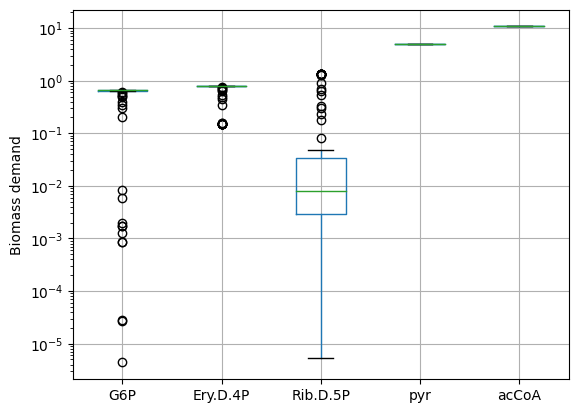

In [21]:
fig, ax = plt.subplots()
fractions_df.boxplot(ax=ax)
ax.set_yscale('log')
ax.set_ylabel('Biomass demand')
display(fig)
plt.close(fig)

### Bonus: use thermodynamics to determine reaction direction
- ΔG0 by reaction
- Metabolite concentrations from Rabinowitz, as ln
- ΔG = ΔG0 + RT ln Q = ΔG0 + RT * s_matrix.T @ ln_concs
- Penalize (flux * ΔG) > 0; also penalize changes to ln_conc (proportional to uncertainty?)
- Optimize \<flux\>\<ln_conc\>

In [26]:
from mosmo.knowledge.thermo import Thermodynamics
thermo = Thermodynamics(p_h=7.3, p_mg=1.5, ionic_strength=0.25, temperature=298.15)

# Concentrations in mM, taken (mostly) from Rabinowitz (2016)
concs = {KB(met_id): conc/1000 for met_id, conc in [
    ('2pg', 9.18e-02),
    ('6pg', 3.77),
    ('6pgdl', 1.), # Not provided; reasonable guess
    ('Ery.D.4P', 4.90e-02),
    ('Fru.D.6P', 2.52),
    ('Fru.D.bis16', 15.2),
    ('Glc.D.ext', 10.),  # Arbitrary; environment
    ('Glc.D.6P', 7.88),
    ('Rib.D.5P', 7.87e-01),
    ('Sed.D.7P', 8.82e-01),
    ('Xul.D.5P', 1.81e-01),
    ('ac', 1e-2),
    ('ac.P', 1.07E-03),
    ('accoa', 6.06e-01),
    ('adp', 5.55e-01),
    ('amp', 2.81e-01),
    ('atp', 9.63),
    ('co2', 7.52e-02),
    ('coa', 1.37),
    ('dpg', 1.65e-02),
    ('nad.ox', 2.55),
    ('nad.red', 8.36e-02),
    ('nadp.ox', 2.08e-03),
    ('nadp.red', 1.21e-01),
    ('pep', 1.84e-01),
    ('pi', 23.9),
    ('pyr', 3.66),

    # Forcing H+ and water to activity = 1.0 excludes them from reaction quotient, to make calculations consistent with eQuilibrator.
    # ('h+', pow(10, -7.3)),
    ('h+', 1000),
    ('h2o', 1000),
    ('e-', 1000),

    # Reported values, though they lead to inconsistent thermodynamic reaction directions
    ('3pg', 1.54),
    ('dhap', 3.06),
    ('gap', 2.71e-01),
    ('Rul.D.5P', 1.12e-01),
]}

dgr0 = network.reactions.pack({rxn: thermo.reaction_delta_g(rxn) for rxn in network.reactions})
dgr_ref = network.reactions.pack({rxn: thermo.reaction_delta_g(rxn, concs) for rxn in network.reactions})
ln_conc_ref = np.log(network.reactants.pack(concs))
RT = thermo.cc.RT.magnitude

In [27]:
ignore = {KB('h+'), KB('h2o'), KB('e-')}
qmask = jnp.array([0 if reactant in ignore else 1 for reactant in network.reactants])
qmatrix = network.s_matrix.T * qmask

def calc_dgr(ln_conc):
    return dgr0 + RT * (qmatrix @ ln_conc)

def thermo_violation(fluxv, ln_conc):
    return jnp.maximum(0, fluxv * calc_dgr(ln_conc))

### Start by _just_ optimizing metabolite concentrations given invariant flux vector

In [28]:
def observed_concs(ln_conc):
    return ln_conc - ln_conc_ref

fluxv = fba_soln.velocities
def fun(x, conc_weight=1.0):
    return jnp.concatenate([thermo_violation(fluxv, x), conc_weight * observed_concs(x)])

_jit = jax.jit(fun, static_argnums=(1,))
_jac = jax.jit(jax.jacfwd(fun), static_argnums=(1,))

In [29]:
dg_soln = scipy.optimize.least_squares(fun=_jit, x0=ln_conc_ref, jac=_jac)
dg_soln

     message: `gtol` termination condition is satisfied.
     success: True
      status: 1
         fun: [ 0.000e+00  0.000e+00 ... -1.664e-01  0.000e+00]
           x: [-4.605e+00 -8.601e+00 ... -1.009e+01  0.000e+00]
        cost: 0.6656921583842974
         jac: [[-0.000e+00 -0.000e+00 ...  0.000e+00  0.000e+00]
               [ 0.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]
               ...
               [ 0.000e+00  0.000e+00 ...  1.000e+00  0.000e+00]
               [ 0.000e+00  0.000e+00 ...  0.000e+00  1.000e+00]]
        grad: [ 0.000e+00  0.000e+00 ... -5.829e-16  0.000e+00]
  optimality: 9.001688283660769e-13
 active_mask: [ 0.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]
        nfev: 2
        njev: 2

In [30]:
for mol, old_conc, new_conc in zip(network.reactants, np.exp(ln_conc_ref), np.exp(dg_soln.x)):
    print(f"{old_conc:.2e} => {new_conc:.2e}   {mol.name}")

1.00e-02 => 1.00e-02   D-glucose (external)
1.84e-04 => 1.84e-04   phosphoenolpyruvate
7.88e-03 => 7.88e-03   D-glucose 6-phosphate
3.66e-03 => 3.66e-03   pyruvate
2.52e-03 => 2.98e-03   D-fructose 6-phosphate
9.63e-03 => 9.48e-03   adenosine 5'-triphosphate
5.55e-04 => 5.64e-04   adenosine 5'-diphosphate
1.52e-02 => 2.68e-02   D-fructose 1,6-bisphosphate
1.00e+00 => 1.00e+00   proton
2.71e-04 => 1.49e-04   D-glyceraldehyde 3-phosphate
3.06e-03 => 2.12e-03   glycerone phosphate
2.55e-03 => 2.55e-03   NAD+
2.39e-02 => 2.39e-02   phosphate
1.65e-05 => 1.68e-05   1,3-bisphospho-D-glycerate
8.36e-05 => 8.36e-05   NADH
1.54e-03 => 1.52e-03   3-phospho-D-glycerate
9.18e-05 => 9.18e-05   2-phospho-D-glycerate
1.00e+00 => 1.00e+00   water
1.37e-03 => 1.37e-03   coenzyme A
6.06e-04 => 6.06e-04   acetyl-CoA
7.52e-05 => 7.52e-05   carbon dioxide
1.07e-06 => 1.07e-06   acetyl phosphate
1.00e-05 => 1.00e-05   acetate
2.08e-06 => 2.08e-06   NADP+
1.00e-03 => 1.00e-03   6-phosphogluconolactone
1.21e-

### Next, optimize flux and concentrations together given the original constraints
- variable vector is \<fluxes\>\<ln_conc\>

In [31]:
# Don't get too clever on regeneralizing just yet.
objectives = {
    'steady-state': ss_objective,
    'growth': growth_objective,
    'uptake': uptake_objective,
}

def fun(x):
    v = x[:network.shape[1]]
    ln_conc = x[-network.shape[0]:]
    dmdt = network.s_matrix @ v
    residuals = []
    for objective in objectives.values():
        residuals.append(objective.residual(v, dmdt, objective.params()))
    residuals.append(thermo_violation(v, ln_conc))
    residuals.append(observed_concs(ln_conc))
    
    return jnp.concatenate(residuals)
                         
_jit = jax.jit(fun)
_jac = jax.jit(jax.jacfwd(fun))


# Solve least squares on combined residual
seed, _seed = jax.random.split(seed)
x0 = jax.random.normal(_seed, (network.shape[1] + network.shape[0],))

soln = scipy.optimize.least_squares(fun=_jit, x0=x0, jac=_jac)


In [32]:
for mol, old_conc, new_conc in zip(network.reactants, np.exp(ln_conc_ref), np.exp(soln.x[network.shape[1]:])):
    print(f"{old_conc:.2e} => {new_conc:.2e}   {mol.name}")
print()
report(growth_objective.growth_rate, soln.x[:network.shape[1]], network.s_matrix @ soln.x[:network.shape[1]])

1.00e-02 => 1.00e-02   D-glucose (external)
1.84e-04 => 1.84e-04   phosphoenolpyruvate
7.88e-03 => 7.88e-03   D-glucose 6-phosphate
3.66e-03 => 3.66e-03   pyruvate
2.52e-03 => 2.52e-03   D-fructose 6-phosphate
9.63e-03 => 9.48e-03   adenosine 5'-triphosphate
5.55e-04 => 5.64e-04   adenosine 5'-diphosphate
1.52e-02 => 2.53e-02   D-fructose 1,6-bisphosphate
1.00e+00 => 1.00e+00   proton
2.71e-04 => 1.45e-04   D-glyceraldehyde 3-phosphate
3.06e-03 => 2.06e-03   glycerone phosphate
2.55e-03 => 2.55e-03   NAD+
2.39e-02 => 2.39e-02   phosphate
1.65e-05 => 1.68e-05   1,3-bisphospho-D-glycerate
8.36e-05 => 8.36e-05   NADH
1.54e-03 => 1.52e-03   3-phospho-D-glycerate
9.18e-05 => 9.18e-05   2-phospho-D-glycerate
1.00e+00 => 1.00e+00   water
1.37e-03 => 1.37e-03   coenzyme A
6.06e-04 => 6.06e-04   acetyl-CoA
7.52e-05 => 7.52e-05   carbon dioxide
1.07e-06 => 1.07e-06   acetyl phosphate
1.00e-05 => 1.00e-05   acetate
2.08e-06 => 2.08e-06   NADP+
1.00e-03 => 1.00e-03   6-phosphogluconolactone
1.21e-